# 🛳️ Titanic Data Investigation

**Scenario:**
You’ve been hired to prepare clean Titanic passenger data for a museum exhibit.
The original data comes from multiple sources.
Your mission is to:
1. Detect and fix missing information
2. Reshape messy structures into tidy format
3. Combine data for richer analysis
4. Transform and normalize values
5. Create one clear visualization for the exhibit

Every wrangling step you take helps make history more understandable!


## 0. Setup & Reproducibility

In [ ]:
!pip install pandas==2.3.3 seaborn==0.13.2 numpy==2.3.4

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
pd.__version__, np.__version__, sns.__version__

('2.3.3', '2.3.4', '0.13.2')

## 1) Load & Inspect

**Goal:** Understand the dataset’s shape, types, and missingness.

**Do this:**
1. Inspect the `titanic` dataset with `head()`, `info()`
2. Count missing values per column
3. Find 4 candidate columns to clean


In [5]:
df = sns.load_dataset("titanic").iloc[:-100]
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [6]:
#SOLUTION
df.info()
df.isna().sum().sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     791 non-null    int64   
 1   pclass       791 non-null    int64   
 2   sex          791 non-null    object  
 3   age          630 non-null    float64 
 4   sibsp        791 non-null    int64   
 5   parch        791 non-null    int64   
 6   fare         791 non-null    float64 
 7   embarked     790 non-null    object  
 8   class        791 non-null    category
 9   who          791 non-null    object  
 10  adult_male   791 non-null    bool    
 11  deck         183 non-null    category
 12  embark_town  790 non-null    object  
 13  alive        791 non-null    object  
 14  alone        791 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 71.7+ KB


deck           608
age            161
embarked         1
embark_town      1
survived         0
pclass           0
sex              0
sibsp            0
parch            0
fare             0
dtype: int64

<details>
<summary>💡 Hint</summary>

- Use `df.info()` to see dtypes and non-null counts
- Use `df.isna().sum()` to count missing values
- Typical targets here: `deck`, `age`, `embarked`
</details>


### Checkpoint 1

In [7]:
expected = {"survived","pclass","sex","age","sibsp","parch","fare","embarked","class","who","adult_male","deck","embark_town","alive"}
assert expected.issubset(set(df.columns))
print("✅")


✅


## 2) Handle Missing Data

**Goal:** Handle common observational missing values.

**Do this:**
1. Fill missing `age` with the **median**
2. Fill missing `embarked` & `embark_town` with the most **common** values of the column
3. Replace missing `deck` with `"Unknown"`
4. Re-check missingness


In [ ]:
##SOLUTION
df["age"].fillna(df["age"].median(), inplace=True)

df["embarked"].fillna(df["embarked"].mode()[0], inplace=True)
df["embark_town"].fillna(df["embark_town"].mode()[0], inplace=True)

df["deck"] = df["deck"].cat.add_categories("Unknown")
df["deck"].fillna("Unknown", inplace=True)

df.isna().sum().sort_values(ascending=False).head(8)

<details>
<summary>💡 Why median/mode?</summary>

- **Age (numeric):** median is robust to outliers
- **Embarked (categorical):** mode reflects the most common category
- **Deck (string):** "Unknown" preserves the fact that a value should exist but wasn’t recorded
</details>


<details>
<summary>💡 Error when trying to fill deck?</summary>

The `deck` column is stored as a *Categorical dtype* in pandas.
To fill missing values with a new label (`"Unknown"`), you must first **add it to the category list**:
```python
df["deck"] = df["deck"].cat.add_categories("Unknown")
```

Alternatively, you can convert deck to string before filling if you don’t need the categorical type:
```python
df["deck"] = df["deck"].astype("string")
```
</details>


### Checkpoint 2

In [ ]:
assert df["age"].isna().sum() == 0
assert df["embarked"].isna().sum() == 0
assert df["deck"].isna().sum() == 0
print("✅")

## 3) Reshape

**Goal:**
You received a **summary sheet** from the museum team.
It shows passenger survival rates, but the layout is **wide** — each embarkation port is a column.
Your job: **convert this wide table back to tidy format**, where each row is one observation.

**Given:**
- A wide DataFrame called `messy`
- Columns: `class`, `sex`, `C`, `Q`, `S` → representing embarkation ports
- Each cell shows the **average survival rate** for that group

**Do this:**
1. Inspect the messy wide table (run the next cell)
2. Use `melt()` to make it tidy again with:
   - `id_vars=["class", "sex"]`
   - `var_name="embarked"`
   - `value_name="survival_rate"`


In [8]:
messy = (
    df.groupby(["class", "sex", "embarked"], observed=True)["survived"]
      .mean()
      .round(3)
      .reset_index()
      .pivot(index=["class", "sex"], columns="embarked", values="survived")
      .reset_index()
)
messy.head()

embarked,class,sex,C,Q,S
0,First,female,0.974,1.00,0.950
1,First,male,0.385,0.00,0.361
2,Second,female,1.000,1.00,0.921
3,Second,male,0.125,0.00,0.165
4,Third,female,0.632,0.75,0.390


In [9]:
#SOLUTION
tidy = messy.melt(
    id_vars=["class","sex"],
    var_name="embarked",
    value_name="survival_rate"
)

tidy.head()


,class,sex,embarked,survival_rate
0,First,female,C,0.974
1,First,male,C,0.385
2,Second,female,C,1.000
3,Second,male,C,0.125
4,Third,female,C,0.632


<details>
<summary>💡 Hint</summary>

- `melt()` reverses a pivot: it takes columns and turns them into rows.
- Use:
  ```python
  tidy = messy.melt(
      id_vars=["class", "sex"],
      var_name="embarked",
      value_name="survival_rate"
  )


In [ ]:
assert set(tidy.columns) == {"class","sex","embarked","survival_rate"}
print("✅")


## 4) Combine

**Goal:**
The museum’s data team discovered new passenger data and prepared **class descriptions** to enrich your dataset.

**Given:**
- A batch of **new rows**: **`new_data`**
- A prepared lookup table: **`class_info`**

**Do this:**
1. **Append** (`concat`) the enriched `new_Data` to `df`
2. Merge **`class_description`** from `class_info` into `df`



In [ ]:
new_data = sns.load_dataset("titanic").tail(100)

In [ ]:
#SOLUTION
df = pd.concat([df, new_data], axis=0, ignore_index=True)

<details>
<summary>💡 Hint (Concat)</summary>

- Use `pd.concat([df, new_rows], axis=0, ignore_index=True)` to append rows.
- `ignore_index=True` re-numbers the index 0..N-1.
</details>


In [ ]:
assert len(df) == 891
print("✅")

#### Merge prepared information

Now the data team gives you an additional **lookup table** named `class_info` that maps the Titanic’s passenger classes
(`First`, `Second`, `Third`) to **descriptive text** and **price category**.

We’ll merge it with `df` on the **'class'** column.


In [ ]:
prev_len = len(df)

class_info = pd.DataFrame({
    "class": ["First", "Second", "Third"],
    "class_description": [
        "First Class – luxury cabins and dining",
        "Second Class – comfortable standard cabins",
        "Third Class – basic accommodation and shared rooms"
    ],
    "price_category": ["high", "mid", "low"]
})

class_info

<details>
<summary>💡 Hint (Merge)</summary>

- Think of `merge()` as connecting tables **by a shared key** (here: <code>'class'</code>).
- Use `how='left'` so every passenger row is kept, even if the key isn't in the lookup.
- Syntax:
  <code>df.merge(class_info, on="class", how="left")</code>
- `validate="m:1"` checks that multiple passengers can map to one class record.
</details>


In [ ]:
#SOLUTION
df_merged = df.merge(
    class_info,
    on="class",
    how="left",
    validate="m:1"
)

df_merged[["class", "sex", "fare", "class_description", "price_category"]].head()

<details>
<summary>💡 Hint (Merge)</summary>

- Your **join keys must match in both *name* and *dtype*** on both sides.
- Since <code>df['fare_band']</code> is an **Interval** and your lookup uses a **string key** (<code>fare_band_key</code>), create a matching key in <code>df</code> with:<br>
  <code>df['fare_band_key'] = df['fare_band'].astype(str)</code>
- Then do a **left merge** on <code>fare_band_key</code> so you keep all rows from <code>df</code>.
- Use <code>validate="m:1"</code> to ensure many-to-one (many passengers → one label per band).
</details>


In [ ]:
assert len(df_merged) == prev_len, "❌ Row count changed, check merge keys."

missing_desc = df_merged["class_description"].isna().sum()
assert missing_desc == 0
print("✅")



## 5) Transform & Normalize

**Goal:**
Improve interpretability and prepare numerical columns for analysis.
We will create new features and scale numerical values for better comparison and visualization.

**Given:**
- A cleaned `df` (after handling missing values).
- Columns such as `fare`, `age`, `sex`, and `embarked`.

**Do this:**
1. Create a **log-transformed** version of `fare` to reduce skew.
2. Create an **age band** column with categories (`Child`, `Young`, `Adult`, `Senior`).
3. Apply **min–max normalization** to `age` and `fare` to bring them to a 0–1 scale.


In [10]:
#Solution
#1
df["log_fare"] = np.log1p(df["fare"])

#2
df["age_band"] = pd.cut(
    df["age"],
    bins=[0, 18, 40, 65, 80],
    labels=["Child", "Young", "Adult", "Senior"]
)

#3
df["age_norm"] = (df["age"] - df["age"].min()) / (df["age"].max() - df["age"].min())
df["fare_norm"] = (df["fare"] - df["fare"].min()) / (df["fare"].max() - df["fare"].min())

<details>
<summary>💡 Hint</summary>

- Use `np.log1p()` for a safe logarithmic transformation (it handles zeros).
- Use `pd.cut()` to bin continuous values into categories.
- Normalization rescales values between 0 and 1:
  x = (x - min(x)) / (max(x) - min(x))
</details>


In [11]:
assert "log_fare" in df.columns
assert "age_norm" in df.columns and 0 <= df["age_norm"].min() <= 1
assert "fare_norm" in df.columns and 0 <= df["fare_norm"].min() <= 1
assert df["log_fare"].isna().sum() == 0 or df["log_fare"].notna().sum() > 0

print("✅")


✅


## 6) Visualize

**Goal:**
Explore insights from the tidy and transformed dataset through simple visualizations.

**Given:**
- A tidy `df` with transformations and normalized numeric columns.

**Do this:**
1. Compare `fare` distributions before and after log transformation.
2. Examine survival rates by sex and passenger class.


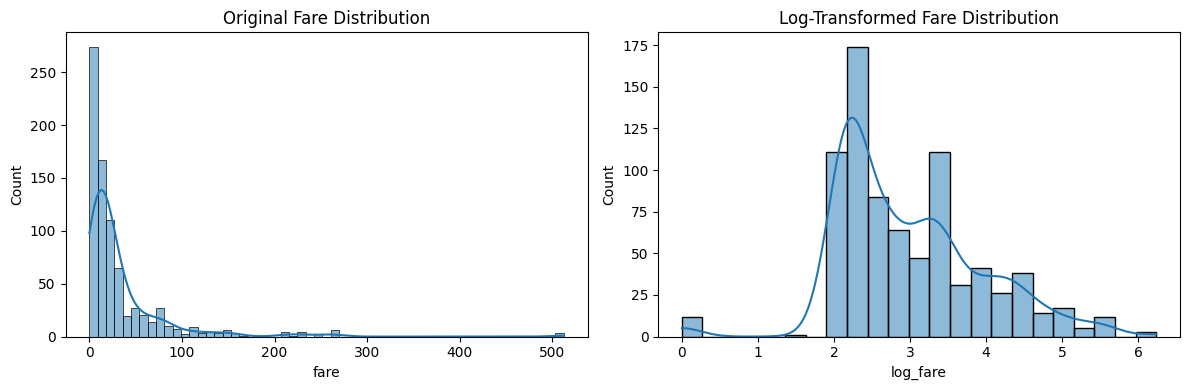

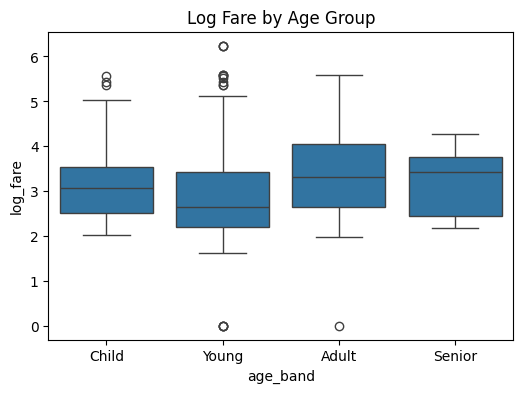

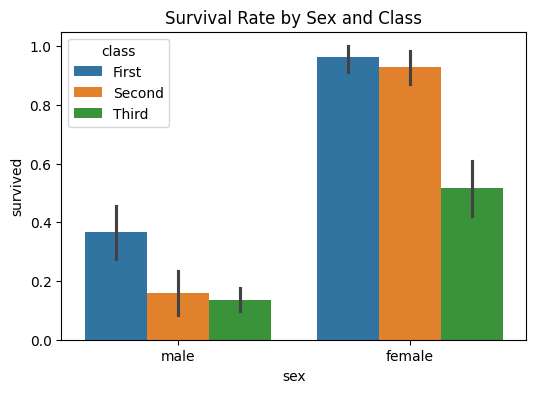

In [12]:
#SOLUTION
# 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["fare"], ax=axes[0], kde=True)
axes[0].set_title("Original Fare Distribution")
sns.histplot(df["log_fare"], ax=axes[1], kde=True)
axes[1].set_title("Log-Transformed Fare Distribution")
plt.tight_layout()
plt.show()

# 3)
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x="sex", y="survived", hue="class")
plt.title("Survival Rate by Sex and Class")
plt.show()

<details>
<summary>💡 Hint</summary>

- `sns.histplot()` is useful to visualize distribution shape and skew.
- `sns.barplot()` shows mean values (by default) and supports grouping via `hue`.
</details>


## 7) Wrap-Up

**Goal:**
Summarize what we learned and confirm that our dataset is now *tidy, clean, and analysis-ready.*
Reflect on how each wrangling step contributed to turning raw Titanic data into structured insight.

**Recap:**
1. **Loaded & Inspected** the dataset to spot issues.
2. **Handled Missing Data** to make gaps explicit and consistent.
2. **Reshaped** and **Combined** messy tables into a tidy format.
4. **Transformed & Normalized** numeric values for interpretability.
5. **Visualized** tidy data to discover patterns and confirm transformations.